In [8]:
from bs4 import BeautifulSoup
import urllib3
import pandas as pd
from unidecode import unidecode
import time

# ASK = input("What type of car you want? ")
# PATH = 'https://divar.ir'
# URL = f'{PATH}/s/iran/auto?q={ASK}'
# EXTRACT = "post-list__items-container-e44b2"


PATH = "https://divar.ir"
URL = f"{PATH}/s/iran/auto?q=206"
EXTRACT = "post-list__items-container-e44b2"


def Requests(path_req, class_type=None, ShowConnection=False):
    req = urllib3.PoolManager()
    res = req.request('GET', path_req)
    if ShowConnection:
        print(res.status)
    soup = BeautifulSoup(res.data, 'html.parser')
    data = soup.findAll('div', {'class':class_type})[0]
    return data


data = Requests(URL, EXTRACT, ShowConnection=True)

200


In [10]:
def ExtractDataFromSite():
    time.sleep(5)
    try:
        data = Requests(URL, EXTRACT)
        time.sleep(10)
        all_values_together = []
        cnt = 0
        for a in data.find_all('a', href=True):
            data_path = a['href']
            NEW_URL = PATH + data_path
            time.sleep(10)
            datasets = Requests(NEW_URL, class_type="post-page__section--padded")
            time.sleep(10)
            rows = datasets.findAll('div', 
                        {'class':"kt-base-row kt-base-row--large kt-unexpandable-row"})
            col_row = {}
            token = {}
            for i, row in enumerate(rows):
                key_value = row.get_text(separator=',')
                if i<=1:
                    pass
                elif i==len(rows)-1:
                    col_row['price'] = float(unidecode(key_value.split(',')[1].split(' ')[0]).replace(',', ''))
                elif key_value.split(',')[1]=='سالم':
                    pass
                else:
                    if key_value.split(',')[1]=='شاسی جلو' or key_value.split(',')[1]=='شاسی عقب':
                        print("Find")
                        token[f'colume_{i}'] = key_value.split(',')[0]
                        col_row[f'colume_{i}'] = key_value.split(',')[1]
                    else:
                        token[f'colume_{i}'] = key_value.split(',')[0]
                        col_row[f'colume_{i}'] = key_value.split(',')[1]
            count = 10     
            for conts, keys in zip(datasets.find_all('td')[:-1], datasets.find_all('th')[:-1]):
                col_row[f'colume_{count}'] = int(float(unidecode(conts.contents[0]).replace(',', '')))
                token[f'colume_{count}'] = keys.text
                count += 1

            col_row['url'] = NEW_URL
            if len(col_row)==8:
                cnt += 1
                all_values_together.append(col_row)
                print(f'Done. URL: {NEW_URL}, {cnt}')
            else:
                print(f"\nThis data is less feature so must removed --> {col_row}, leght {len(col_row)}\n")
            if cnt==120:
                break
            

    except Exception as error:
        print("Request is Refus please try again." , error)

    return all_values_together, token


dataset, token = ExtractDataFromSite()
print(f"Dataset is: {dataset}, Token is: {token}")

Done. URL: https://divar.ir/v/پژو-206-sd-v9-مدل-۱۳۹۱/QZwD5uzU, 0
This data is less feature so must removed --> {'colume_3': 'سالم و پلمپ', 'colume_4': 'دوررنگ', 'colume_5': '۶ ماه', 'colume_6': 'دنده\u200cای', 'colume_7': 'هستم', 'price': 180000000.0, 'colume_10': 350000, 'colume_11': 1382, 'url': 'https://divar.ir/v/پژو-206-تیپ-۲-مدل-۱۳۸۲-فنی-به-شرط/QZ2jwpvQ'}, leght 9
Done. URL: https://divar.ir/v/پژو-206-sd-v8-مدل-۱۳۹۵/gZDIyt9m, 2
Done. URL: https://divar.ir/v/پژو-206-تیپ-۲-مدل-۱۳۹۷/gZDISVl3, 3
This data is less feature so must removed --> {'colume_3': 'دوررنگ', 'colume_4': '۹ ماه', 'colume_5': 'دنده\u200cای', 'price': 365000000.0, 'colume_10': 100000, 'colume_11': 1397, 'url': 'https://divar.ir/v/پژو-206-تیپ-۲-مدل-۱۳۹۷-tu3/gZDIiUqP'}, leght 7
This data is less feature so must removed --> {'colume_3': 'سالم و پلمپ', 'colume_4': 'سالم و بی\u200cخط و خش', 'colume_5': '۹ ماه', 'colume_6': 'دنده\u200cای', 'colume_7': 'هستم', 'price': 550000000.0, 'colume_10': 23000, 'colume_11': 1399, '

In [11]:
len(dataset), token

(17,
 {'colume_3': 'وضعیت شاسی\u200cها',
  'colume_4': 'وضعیت بدنه',
  'colume_5': 'مهلت بیمهٔ شخص ثالث',
  'colume_6': 'گیربکس',
  'colume_10': 'کارکرد',
  'colume_11': 'مدل (سال تولید)'})

In [15]:
ENV_TOKEN = {
            'colume_4' : {'خط و خش جزیی':85
                           ,'رنگ‌شدگی':45
                           ,'سالم و بی‌خط و خش':100 
                           ,',دوررنگ':10,
                          'تمام‌رنگ':10 ,
                         'دوررنگ':10 ,
                         'صافکاری بی‌رنگ':75},
    
             'colume_3' : {'سالم و پلمپ':90, 
                           'ضربه‌خورده':10},
             'colume_6' : {'اتوماتیک':1, 
                           'دنده\u200cای':0}
}

In [16]:
for data in dataset:
    for key in data.keys():
        try:
            data[key] = ENV_TOKEN[key][data[key]]
        except Exception as cannot:
            pass
    

In [17]:

for index, data in enumerate(dataset):
    if index==0:
        df = pd.DataFrame([data])
    else:
        df.loc[len(df)] = data
    

In [18]:
df

,colume_3,colume_4,colume_5,colume_6,price,colume_10,colume_11,url
0,90,45,۴ ماه,1,420000000.0,280000,1391,https://divar.ir/v/پژو-206-sd-v9-مدل-۱۳۹۱/QZwD...
1,90,100,۵ ماه,0,48500000.0,1800,1395,https://divar.ir/v/پژو-206-sd-v8-مدل-۱۳۹۵/gZDI...
2,90,100,۹ ماه,0,395000000.0,100000,1397,https://divar.ir/v/پژو-206-تیپ-۲-مدل-۱۳۹۷/gZDI...
3,90,100,۱۱ ماه,0,480000000.0,68000,1398,https://divar.ir/v/پژو-206-تیپ-۲-مدل-۱۳۹۸/gZDA...
4,90,45,۵ ماه,0,380000000.0,134000,1394,https://divar.ir/v/پژو-206-تیپ-۵-مدل-۱۳۹۴/gZDE...
5,90,100,۳ ماه,0,530000000.0,120000,1397,https://divar.ir/v/پژو-206-تیپ-۵-مدل-۱۳۹۷-بدون...
6,90,85,۸ ماه,0,270000000.0,235000,1388,https://divar.ir/v/پژو-206-تیپ-۲-مدل-۱۳۸۸/gZDE...
7,10,45,۱۲ ماه,0,220000000.0,400000,1384,https://divar.ir/v/پژو-206-تیپ-۲-مدل۸۴/gZDEidxP
8,90,100,۱۰ ماه,0,505000000.0,70000,1399,https://divar.ir/v/پژو-206-تیپ-۲-مدل-۱۳۹۹/gZDg...
9,90,45,۴ ماه,0,370000000.0,188000,1391,https://divar.ir/v/پژو-206-تیپ-۲-مدل-۱۳۹۱/gZDE...


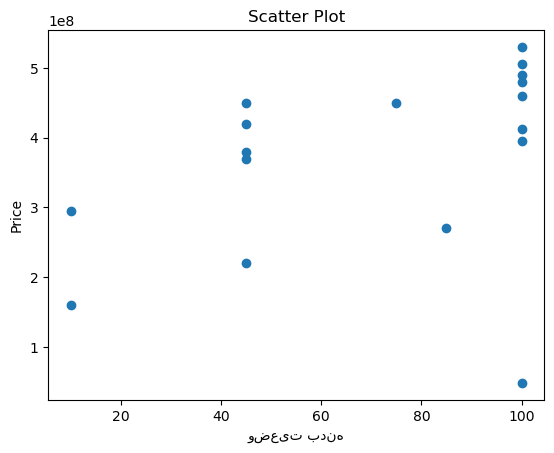

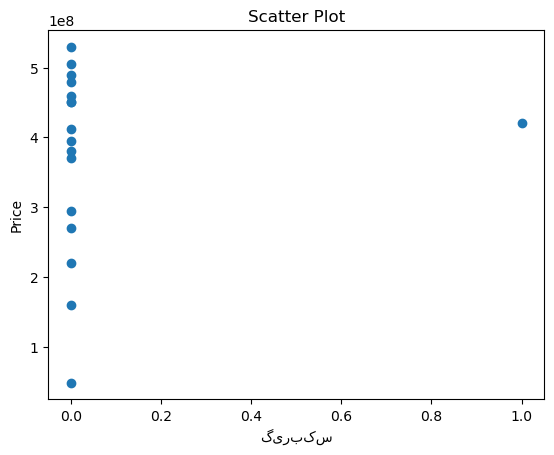

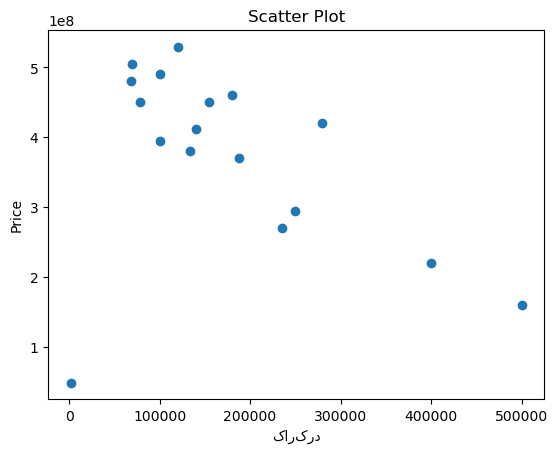

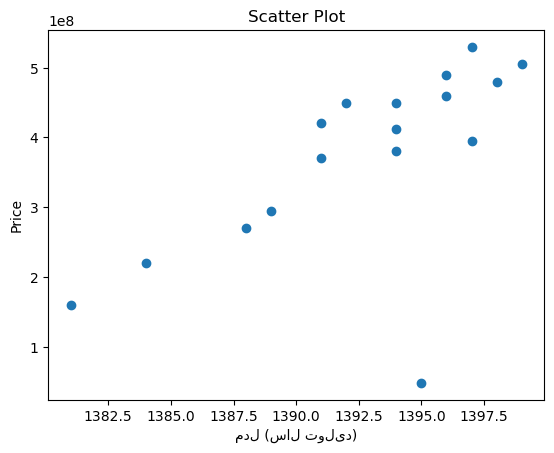

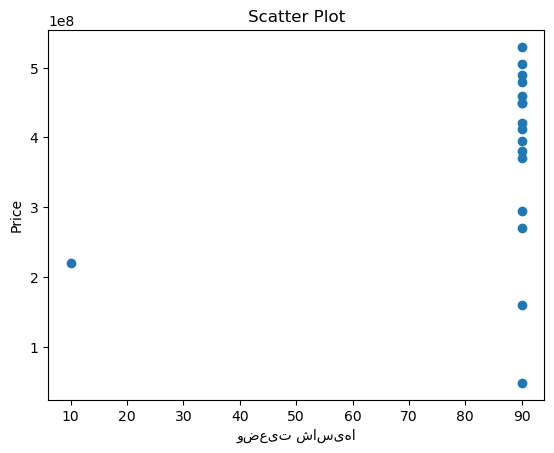

In [21]:
import matplotlib.pyplot as plt

ImportantColumn = ['colume_4', 'colume_6', 'colume_10', 'colume_11', 'colume_3']
for col in ImportantColumn:
    plt.scatter(df[col], df['price'])
    plt.title("Scatter Plot")
    plt.xlabel(token[col])
    plt.ylabel('Price')
    plt.show()

In [22]:
df = df[['colume_4', 'colume_6', 'colume_10', 'colume_11', 'price', 'url']]
df

,colume_4,colume_6,colume_10,colume_11,price,url
0,45,1,280000,1391,420000000.0,https://divar.ir/v/پژو-206-sd-v9-مدل-۱۳۹۱/QZwD...
1,100,0,1800,1395,48500000.0,https://divar.ir/v/پژو-206-sd-v8-مدل-۱۳۹۵/gZDI...
2,100,0,100000,1397,395000000.0,https://divar.ir/v/پژو-206-تیپ-۲-مدل-۱۳۹۷/gZDI...
3,100,0,68000,1398,480000000.0,https://divar.ir/v/پژو-206-تیپ-۲-مدل-۱۳۹۸/gZDA...
4,45,0,134000,1394,380000000.0,https://divar.ir/v/پژو-206-تیپ-۵-مدل-۱۳۹۴/gZDE...
5,100,0,120000,1397,530000000.0,https://divar.ir/v/پژو-206-تیپ-۵-مدل-۱۳۹۷-بدون...
6,85,0,235000,1388,270000000.0,https://divar.ir/v/پژو-206-تیپ-۲-مدل-۱۳۸۸/gZDE...
7,45,0,400000,1384,220000000.0,https://divar.ir/v/پژو-206-تیپ-۲-مدل۸۴/gZDEidxP
8,100,0,70000,1399,505000000.0,https://divar.ir/v/پژو-206-تیپ-۲-مدل-۱۳۹۹/gZDg...
9,45,0,188000,1391,370000000.0,https://divar.ir/v/پژو-206-تیپ-۲-مدل-۱۳۹۱/gZDE...
